# Fine-tuning CLIP
Run the following cell if running this Jupyter Notebook on Google Colab to install additional necessary libraries before you begin. If you are running this on your Vertex AI Workbench Instance, you will likely already have installed these libraries.

In [1]:
%%capture
# for google Colab
!pip install accelerate transformers==4.37.0 datasets

## Initialize CLIP Model
Here we initialize the CLIP model as well as a particular tokenizer; here we've chosen the RoBERTa tokenizer.

In [2]:
import torch
from datasets import load_dataset
from PIL import Image
from torchvision.io import ImageReadMode, read_image
from torchvision.transforms import CenterCrop, ConvertImageDtype, Normalize, Resize
from torchvision.transforms.functional import InterpolationMode
from transformers import (
    Trainer,
    TrainingArguments,
    VisionTextDualEncoderModel,
    VisionTextDualEncoderProcessor,
    AutoTokenizer,
    AutoImageProcessor
)

model = VisionTextDualEncoderModel.from_vision_text_pretrained(
    "openai/clip-vit-base-patch32", "FacebookAI/roberta-base"
)

tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base")
image_processor = AutoImageProcessor.from_pretrained("openai/clip-vit-base-patch32")
processor = VisionTextDualEncoderProcessor(image_processor, tokenizer)
config = model.config

/opt/conda/envs/python310cv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The projection layer and logit scale weights `['visual_projection.weight', 'text_projection.weight', 'logit_scale']` are newly initialized. You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature

Now we load our datasets. Here we're loading a small dummy COCO dataset.

In [3]:
# load datasets, loading dummy COCO dataset for this
dataset = load_dataset("ydshieh/coco_dataset_script", "2017", data_dir="./dummy_data/", trust_remote_code=True)

Repo card metadata block was not found. Setting CardData to empty.


# Example of data (image, text pairs)

Text(0.5, 1.0, 'A picture of a dog laying on the ground.')

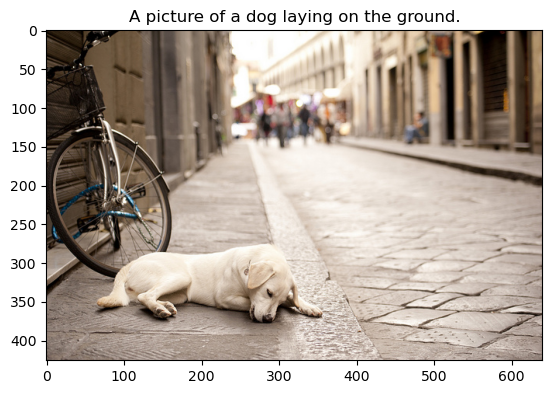

In [4]:
import matplotlib.pyplot as plt

img = Image.open(dataset['train']['image_path'][0])
caption = dataset['train']['caption'][0]
plt.imshow(img)
plt.title(caption)

Text(0.5, 1.0, 'This wire metal rack holds several pairs of shoes and sandals')

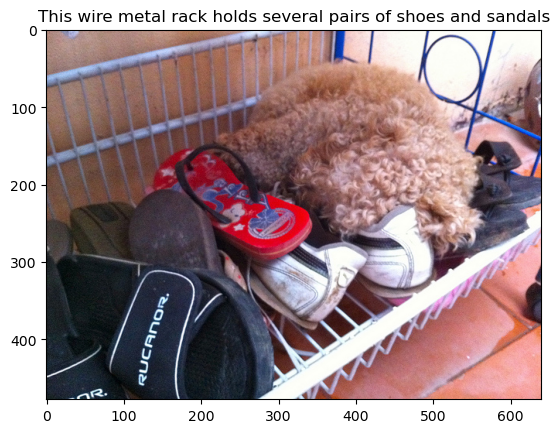

In [5]:
img = Image.open(dataset['train']['image_path'][10])
caption = dataset['train']['caption'][10]
plt.imshow(img)
plt.title(caption)

# Preprocess the data

We need to pre-process our dataset such that our model will be able to recognize it. So first we define our image preprocessing logic (e.g. resizing, converting to the correct datatype, normalization, etc.), as well as our text preprocessing logic (i.e. tokenization), then apply it to our datasets, both train and eval.

In [6]:
# We use torchvision for faster image pre-processing. The transforms are implemented as nn.Module,
# so we jit it to be faster.
class Transform(torch.nn.Module):
    def __init__(self, image_size, mean, std):
        super().__init__()
        self.transforms = torch.nn.Sequential(
            Resize([image_size], interpolation=InterpolationMode.BICUBIC),
            CenterCrop(image_size),
            ConvertImageDtype(torch.float),
            Normalize(mean, std),
        )

    def forward(self, x) -> torch.Tensor:
        """`x` should be an instance of `PIL.Image.Image`"""
        with torch.no_grad():
            x = self.transforms(x)
        return x

# For preprocessing the datasets.
# Initialize torchvision transforms and jit it for faster processing.
image_transformations = Transform(
    config.vision_config.image_size, image_processor.image_mean, image_processor.image_std
)
image_transformations = torch.jit.script(image_transformations)

In [7]:
def preprocess_dataset(dataset, split):
    # Preprocessing the datasets.
    data = dataset[split]
    # We need to tokenize inputs and targets.
    column_names = data.column_names

    # 6. Get the column names for input/target.
    image_column = "image_path"
    caption_column = "caption"
    dataset_columns = (image_column, caption_column)

    # Preprocessing the datasets.
    # We need to tokenize input captions and transform the images.
    def tokenize_captions(examples):
        captions = list(examples[caption_column])
        text_inputs = tokenizer(captions, padding="max_length", truncation=True)
        examples["input_ids"] = text_inputs.input_ids
        examples["attention_mask"] = text_inputs.attention_mask
        return examples

    def transform_images(examples):
        images = [read_image(image_file, mode=ImageReadMode.RGB) for image_file in examples[image_column]]
        examples["pixel_values"] = [image_transformations(image) for image in images]
        return examples

    data = data.map(
        function=tokenize_captions,
        batched=True,
        remove_columns=[col for col in column_names if col != image_column],
        desc=f"Running tokenizer on {split} dataset",
    )

    # Transform images on the fly as doing it on the whole dataset takes too much time.
    data.set_transform(transform_images)
    return data

In [8]:
train_dataset = preprocess_dataset(dataset, "train")
eval_dataset = preprocess_dataset(dataset, "validation")

Parameter 'transform'=<function preprocess_dataset.<locals>.transform_images at 0x7efc72bf05e0> of the transform datasets.arrow_dataset.Dataset.set_format couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Running tokenizer on validation dataset:   0%|          | 0/80 [00:00<?, ? examples/s]

Finally we need to write a small function to handle the batching logic for our training. This collates all passed training items in the batch together such that we can pass it to the model for training, along with the kwarg `return_loss=True` such that the model will return its loss for backpropagation.

In [9]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    input_ids = torch.tensor([example["input_ids"] for example in examples], dtype=torch.long)
    attention_mask = torch.tensor([example["attention_mask"] for example in examples], dtype=torch.long)
    return {
        "pixel_values": pixel_values,
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "return_loss": True,
    }

# Train

Now we're ready to actually train our CLIP model!

In [13]:
# initialize Trainer
training_args = TrainingArguments(
    learning_rate=5e-5,
    warmup_steps=0,
    weight_decay=0.1,
    per_device_train_batch_size=16,
    logging_steps=5,
    save_steps=5,
    remove_unused_columns=False,
    output_dir="clip-finetune",
    report_to='none', # disable wandb
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=collate_fn,
)
train_result = trainer.train()

Step,Training Loss
5,2.731700
10,1.988500
15,1.355800


In [11]:
metrics = trainer.evaluate()
print(metrics)

{'eval_loss': 2.0890517234802246, 'eval_runtime': 2.916, 'eval_samples_per_second': 27.435, 'eval_steps_per_second': 3.429, 'epoch': 3.0}


Once the model is trained, we can save it to our defined `output_dir` (in this case `clip-finetune`) so we can import it into our applications later.

In [12]:
trainer.save_model("clip-finetune")
tokenizer.save_pretrained("clip-finetune")
image_processor.save_pretrained("clip-finetune")

['clip-finetune/preprocessor_config.json']

## Resources
* [HF Transformers on training CLIP](https://github.com/huggingface/transformers/tree/main/examples/pytorch/contrastive-image-text)